<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [1]:
def ft0(image):
    return image.size
# Returns the pixel size of the image
def ft1(image):
    if len(image.shape) == 2: #if the image is in gray scale
        return np.mean(image)
    return np.mean(image[:,:,0])
# Returns the average of the red-channel pictures for the images
def ft2(image):
    return image.shape[0]/image.shape[1]
#Returns the aspect ratio of the image

In [557]:
def ft3(image):
    """average of the blue-channel intensity - scalar feature"""
    if len(image.shape) == 2:
        return np.mean(image)
    return np.mean(image[:,:,1])
def ft4(image):
    """average of the green-channel intensity - scalar feature"""
    if len(image.shape) == 2:
        return np.mean(image)
    return np.mean(image[:,:,2])
def ft5(image):
    """Harris Corner Detection - vector feature"""
    coords = corner_peaks(corner_harris(rgb2gray(image)), min_distance=5)
    return coords.reshape(1,-1)
def ft6(image):
    """Histogram of Oriented Gradients - vector feature"""
    fd, _ = hog(resize(rgb2gray(image)), orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
    return fd.reshape(1,-1)
def ft7(image):
    """Mean intensity of image - scalar feature"""
    return np.mean(rgb2gray(image))
def ft8(image):
    """First 20 principal components - vector feature"""
    image = resize(rgb2gray(image))
    X = image.copy() - image.mean(axis=1)
    _,_,vt = np.linalg.svd(X)
    return vt[0:20].reshape(1,-1)
def ft9(image):
    """Total variance - scalar feature"""
    return image.var()
def ft10(image):
    """product of channel intensities - scalar feature"""
    return ft1(image)*ft3(image)*ft4(image)
def ft11(image):
    """Total ratio of blue over other channels - scalar feature"""
    return ft3(image) / (ft1(image)+ft4(image))
def ft12(image):
    """returns black and white 30x30 image - vector feature"""
    return resize(rgb2gray(image), (30,30)).reshape(1,-1)
def ft13(image, clf_GM):
    """returns the prediction of a previously trained gaussian mixture model - scalar feature"""
    return clf_GM.predict(image)
def ft14(image):
    """product of ratio of blue and mean image intensity"""
    return np.log(ft11(image)+ft7(image))

 We expect all external sources sited, and significant indication of EDA. 

<h4> Graphs </h4>

In [19]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [4]:
encoding = ['Airplanes', 'Bear', 'Blimp', 'Comet', 'Crab', 'Dog', 'Dolphin', 'Giraffe', 'Goat', 'Gorilla', 'Kangaroo', 'Killer-Whale', 'Leopards', 'Llama', 'Penguin', 'Porcupine', 'Teddy-Bear', 'Triceratops', 'Unicorn', 'Zebra']

In [539]:
starting_data = pd.DataFrame(np.load('starting_data.npy'), columns=['Pictures','Encoding'])

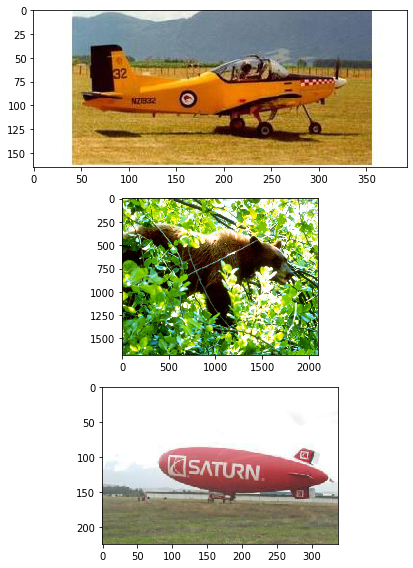

In [289]:
plt.figure(figsize=(16,8))
for i in range(3):
    plt.subplot(3,1,i+1)
    image = starting_data[starting_data.Encoding == i].Pictures.iloc[0]
    io.imshow(image);

### Image Sizes

In [527]:
import seaborn as sns

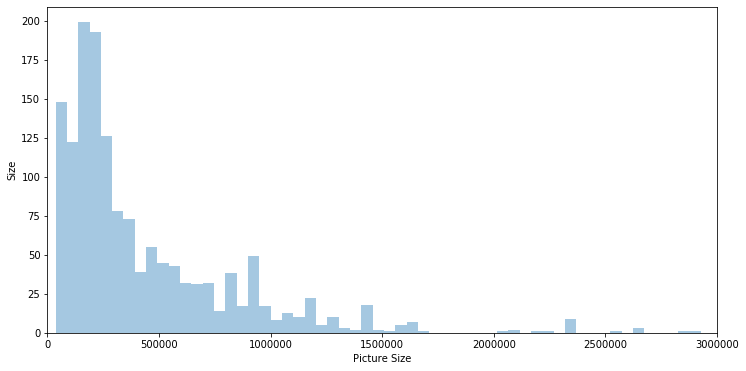

In [291]:
sizes = starting_data.Pictures.apply(ft0)
plt.figure(figsize=(12,6))
sns.distplot(sizes, bins=500, kde=None)
plt.xlim((0,3*1e6))
plt.xlabel('Picture Size')
plt.ylabel('Size');

### Pixel intensities

In [530]:
red = starting_data.Pictures.apply(ft1)
green = starting_data.Pictures.apply(ft3)
blue = starting_data.Pictures.apply(ft4)

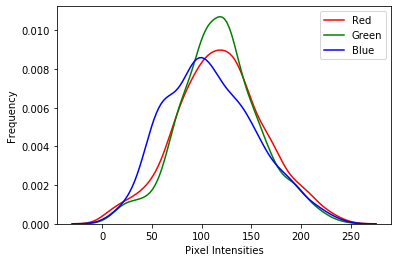

In [531]:
sns.distplot(red, label='Red', hist = None, color='r')
sns.distplot(green, label='Green', hist = None, color='g')
sns.distplot(blue, label='Blue', hist = None, color='b')
plt.xlabel('Pixel Intensities')
plt.ylabel('Frequency')
plt.legend();

### Aspect Ratio

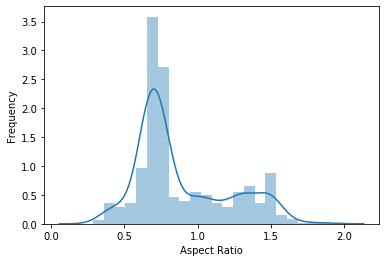

In [129]:
aspect_ratio = starting_data.Pictures.apply(ft2)
sns.distplot(aspect_ratio)
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency');

### Class Frequencies

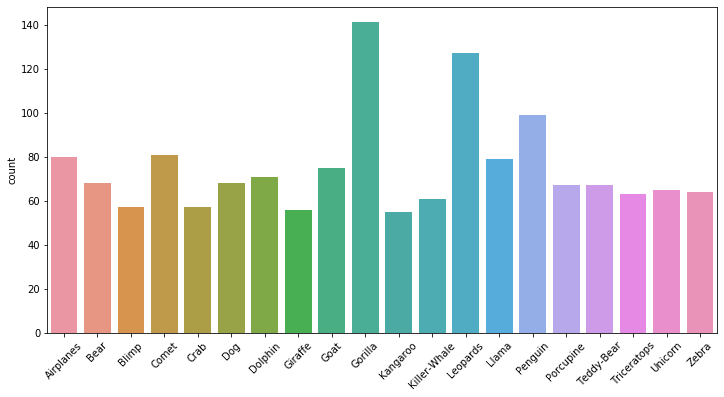

In [55]:
plt.figure(figsize=(12,6))
class_frequencies = starting_data.Encoding.copy()
for i in range(len(encoding)):
    class_frequencies.replace({i:encoding[i]}, inplace = True)
sns.countplot(class_frequencies.values)
plt.xticks(rotation = 45);

### Harris Corner Detection

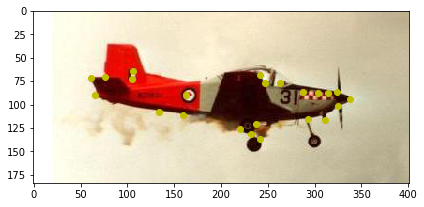

In [128]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.color import rgb2gray

image = starting_data.Pictures.iloc[3]
coords = ft5(image)
io.imshow(image)
plt.scatter(np.array(coords[:,1]), np.array(coords[:,0]), c='y');

### Histogram of Oriented Gradients

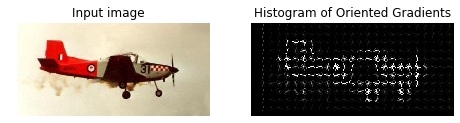

In [65]:
from skimage.feature import hog
from skimage import data, exposure

image = starting_data.Pictures.iloc[3]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Flattening images in black and white

In [31]:
def resize(image, target_size=(40,40)):
    """
    resizes image and adds zero padding so that it is 224*224
    updates the bboxes (nparray) to match the new image
    returns the new image as nparray and y_true as a dict 'classes' and 'bboxes' (nparray)
    """
    ih, iw    = target_size
    h,  w = image.shape[0], image.shape[1]

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))
    

    image_paded = np.zeros((ih, iw))
    dw, dh = (iw-nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw] = image_resized #the original image is centered
    image_paded = image_paded / 255.
    return image_paded

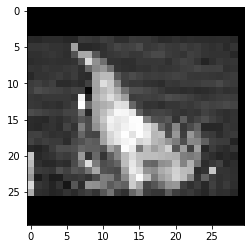

In [118]:
plt.imshow(resize(rgb2gray(starting_data.Pictures.iloc[430]), (30,30)), cmap='gray')

### Principal Component Analysis (ft8) - vector feature

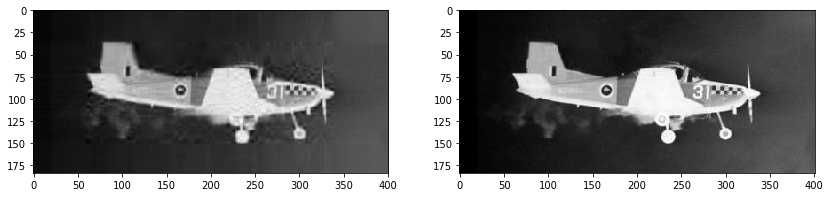

In [573]:
X = rgb2gray(image).copy() - image.mean(axis=2)
u, s, vt = np.linalg.svd(X)
new_X = X.dot(vt[0:20].T).dot(vt[0:20])
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(new_X, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X, cmap='gray')

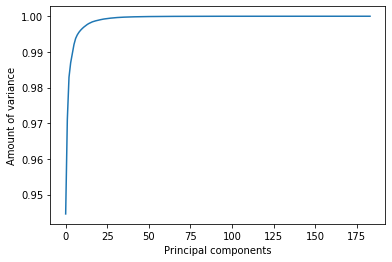

In [574]:
plt.plot(np.cumsum(s**2/np.sum(s**2)))
plt.xlabel('Principal components')
plt.ylabel('Amount of variance');

### Mean Intensity (ft7) - scalar feature
Can help differentiate certain classes such as Blimp, Comet, Crab, Dolphin or Gorilla

In [575]:
mean_intensity = starting_data.Pictures.apply(ft7)

In [525]:
labels = starting_data.Encoding.apply(lambda s: encoding[s])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

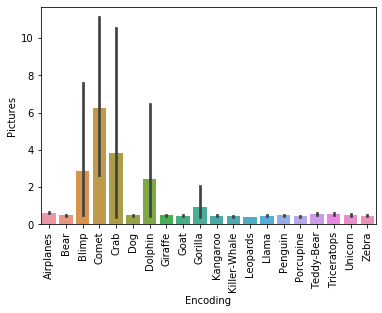

In [305]:
sns.barplot(x = labels, y = mean_intensity)
plt.xticks(rotation = 90);

### Image Variance (ft9) - scalar feature
Can help identify classes with high or low variance such as Comet, Airplanes, Leopards, Triceratops, etc...

In [548]:
variance = starting_data.Pictures.apply(ft9)

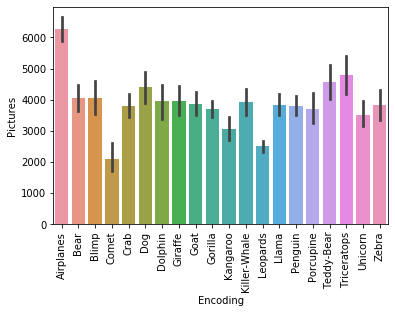

In [325]:
sns.barplot(x = labels, y = variance)
plt.xticks(rotation = 90);

### Multiplying pixel intensities (ft10) - scalar feature

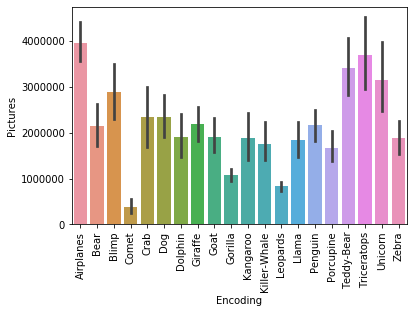

In [553]:
ft10_ = starting_data.Pictures.apply(ft10)
sns.barplot(x = labels, y = ft10_)
plt.xticks(rotation = 90);

### Total ratio of blue over all channels (ft11) - scalar feature

Taking the total ratio of other channels does not yield a significant result.

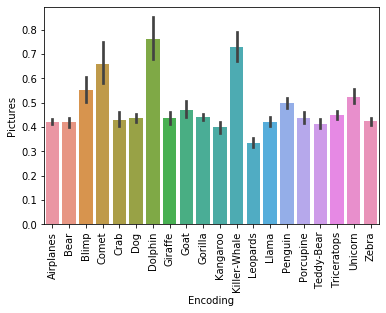

In [554]:
ft11_ = blue/(green+red)
sns.barplot(x = labels, y = ft11_)
plt.xticks(rotation = 90);

### Product of total ratio of blue and mean image intensity (ft14) - scalar feature

Can allow us to differenciate classes in a better way than some of the previous scalar features. The big issue here is the intra-class variance though.

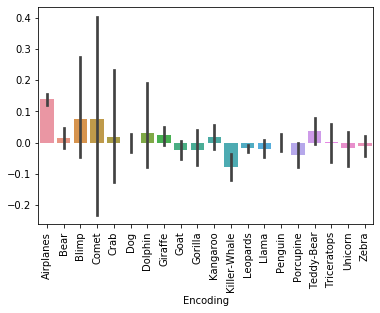

In [558]:
ft14_ = starting_data.Pictures.apply(ft14).values
sns.barplot(x = labels, y = ft14_)
plt.xticks(rotation = 90);

<h4> Sources </h4>

https://scikit-image.org/docs/0.6/auto_examples/plot_harris.html
<br>https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
<br>https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html

<h4> DataFrame Creation </h4>

In [559]:
from sklearn.mixture import GaussianMixture

def feature_frame(df, features = [ft1, ft3, ft6, ft11, ft12, ft14]): #PLUS the Mixture of Gaussians Model
    features_list = []
    for feature in features:
        ft = df.Pictures.apply(feature).values
        if ft[0].shape == ():
            features_list.append(ft[:, np.newaxis])
        else:
            features_list.append(np.concatenate(ft, axis=0))
    y = df.Encoding.astype(float).values[:, np.newaxis]
    df = np.concatenate(tuple(features_list), axis=1)
    clf_GM = GaussianMixture(n_components = 20).fit(df)
    return np.concatenate((df, clf_GM.predict(df)[:, np.newaxis], y), axis=1)
    #Returns data-frame with all the features now inside, and calculated

In [560]:
features_df = feature_frame(starting_data)